In [70]:
import pandas as pd 
import numpy as np 
import missingno as msno
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
import shap
from joblib import dump, load

In [71]:
df_02 = pd.read_csv(r'C:\Users\LENOVO\Documents\GitHub\ML_PowerBI\data\processed\df_imp.csv')
df_02.head()

,AccountAge,MonthlyCharges,SubscriptionType,PaymentMethod,PaperlessBilling,ContentType,MultiDeviceAccess,DeviceRegistered,ViewingHoursPerWeek,AverageViewingDuration,ContentDownloadsPerMonth,GenrePreference,SupportTicketsPerMonth,Gender,WatchlistSize,ParentalControl,CustomerID,Churn,TotalCharges_log
0,42,11.321950,Basic,Electronic check,Yes,Movies,Yes,Tablet,0.386852,24.593361,25,Comedy,7,Female,15,No,LOHRYYC9E8,0,6.166514
1,95,12.810915,Standard,Electronic check,Yes,TV Shows,No,Mobile,37.123000,102.860795,21,Comedy,3,Male,8,No,RIH7RFEZCS,0,7.104996
2,6,10.400706,Standard,Credit card,Yes,TV Shows,No,Tablet,30.716944,10.512415,29,Fantasy,4,Male,14,No,JB5J8X2UY1,1,4.528109
3,54,17.917819,Basic,NaN,Yes,Movies,No,Mobile,2.495373,45.246834,45,Drama,3,Male,12,No,Z4GZJIB90P,0,6.875813
4,27,11.005068,Basic,Mailed check,No,TV Shows,No,Mobile,39.936910,94.310954,44,Comedy,4,Female,18,No,B3BDJTW0L9,0,5.829114


In [72]:
df_02.isnull().sum()

AccountAge                    0
MonthlyCharges                0
SubscriptionType              0
PaymentMethod               223
PaperlessBilling              0
ContentType                   0
MultiDeviceAccess             0
DeviceRegistered              0
ViewingHoursPerWeek           0
AverageViewingDuration        0
ContentDownloadsPerMonth      0
GenrePreference               0
SupportTicketsPerMonth        0
Gender                        0
WatchlistSize                 0
ParentalControl               0
CustomerID                    0
Churn                         0
TotalCharges_log              0
dtype: int64

In [73]:
df_02.to_csv(r'C:\Users\LENOVO\Documents\GitHub\ML_PowerBI\data\processed\df_02.csv', index=False)

In [74]:
df_02.head()

,AccountAge,MonthlyCharges,SubscriptionType,PaymentMethod,PaperlessBilling,ContentType,MultiDeviceAccess,DeviceRegistered,ViewingHoursPerWeek,AverageViewingDuration,ContentDownloadsPerMonth,GenrePreference,SupportTicketsPerMonth,Gender,WatchlistSize,ParentalControl,CustomerID,Churn,TotalCharges_log
0,42,11.321950,Basic,Electronic check,Yes,Movies,Yes,Tablet,0.386852,24.593361,25,Comedy,7,Female,15,No,LOHRYYC9E8,0,6.166514
1,95,12.810915,Standard,Electronic check,Yes,TV Shows,No,Mobile,37.123000,102.860795,21,Comedy,3,Male,8,No,RIH7RFEZCS,0,7.104996
2,6,10.400706,Standard,Credit card,Yes,TV Shows,No,Tablet,30.716944,10.512415,29,Fantasy,4,Male,14,No,JB5J8X2UY1,1,4.528109
3,54,17.917819,Basic,NaN,Yes,Movies,No,Mobile,2.495373,45.246834,45,Drama,3,Male,12,No,Z4GZJIB90P,0,6.875813
4,27,11.005068,Basic,Mailed check,No,TV Shows,No,Mobile,39.936910,94.310954,44,Comedy,4,Female,18,No,B3BDJTW0L9,0,5.829114


**Comentario** No indexaré CustomerId en el tabla porque lo necesito más adelante. 

In [75]:
customer_ids = df_02['CustomerID']

## 2. Partición y feature engineering

In [76]:
# Separamos variables del objetivo (churn)
X = df_02.drop(columns=['Churn','CustomerID'])
y = df_02['Churn']

# Partición train/test
X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(
    X, y, customer_ids,
    test_size=0.2,
    random_state=42,
)

In [100]:
# Guardar IDs de test en CSV
id_test.to_csv(r'C:\Users\LENOVO\Documents\GitHub\ML_PowerBI\data\processed\id_test.csv', index=False)

#### 2.1 Imputación de la variable PaymentMethod a partir de otras variables con RF

In [77]:
#Selección de filas con y sin PaymentMethod en train
train_payment_complete = X_train[X_train['PaymentMethod'].notna()]
X_train_missing = X_train[X_train['PaymentMethod'].isna()]

In [78]:
#Selección de variables relacionadas
features_num = ['MonthlyCharges', 'TotalCharges_log', 'AccountAge']

# Entrenar RF solo con filas completas de train
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(train_payment_complete[features_num], train_payment_complete['PaymentMethod'])

# Predecir PaymentMethod en train (solo filas con NaN)
preds_train = pd.Series(
    rf.predict(X_train_missing[features_num]),
    index=X_train_missing.index
)
X_train.loc[X_train_missing.index, 'PaymentMethod'] = preds_train

# Imputar PaymentMethod en test usando modelo entrenado en train
X_test_missing = X_test[X_test['PaymentMethod'].isna()]
preds_test = pd.Series(
    rf.predict(X_test_missing[features_num]),
    index=X_test_missing.index
)
X_test.loc[X_test_missing.index, 'PaymentMethod'] = preds_test

In [79]:
# Verificación
print("Train PaymentMethod:")
print(X_train['PaymentMethod'].value_counts())
print("\nTest PaymentMethod:")
print(X_test['PaymentMethod'].value_counts())

Train PaymentMethod:
PaymentMethod
Credit card         264
Electronic check    226
Bank transfer       224
Mailed check         56
Name: count, dtype: int64

Test PaymentMethod:
PaymentMethod
Credit card         67
Bank transfer       56
Electronic check    55
Mailed check        15
Name: count, dtype: int64


### 2.2 One Hot Encoding para las variables categóricas

In [80]:
#Selección de las columnas categóricas
categorical_cols = X_train.select_dtypes(include=['object']).columns

In [81]:
# Crear el encoder
ohe = OneHotEncoder(
    drop='first',              # elimina 1 categoría por dummy trap (evitar redundancia)
    handle_unknown='ignore',   # categorías nuevas en test -> columnas en 0
    sparse_output=False        # matriz densa
)

# Ajustar SOLO con train
X_train_encoded = ohe.fit_transform(X_train[categorical_cols])

# Transformar test usando el mismo encoder
X_test_encoded  = ohe.transform(X_test[categorical_cols])

In [82]:
ohe_columns = ohe.get_feature_names_out(categorical_cols)
dump(ohe_columns, r"C:\Users\LENOVO\Documents\GitHub\ML_PowerBI\models\ohe_columns.joblib")
dump(ohe, r"C:\Users\LENOVO\Documents\GitHub\ML_PowerBI\models\ohe_encoder.joblib")

['C:\\Users\\LENOVO\\Documents\\GitHub\\ML_PowerBI\\models\\ohe_encoder.joblib']

In [83]:
# Crear DataFrame con las categorías codificadas
X_train_encoded_df = pd.DataFrame(
    X_train_encoded,
    index=X_train.index,
    columns=ohe.get_feature_names_out(categorical_cols)
)

In [84]:
# Crear DataFrame con las categorías codificadas
X_test_encoded_df = pd.DataFrame(
    X_test_encoded,         
    index=X_test.index,      
    columns=ohe.get_feature_names_out(categorical_cols)
)

In [85]:
X_train_encoded_df.columns

Index(['SubscriptionType_Premium', 'SubscriptionType_Standard',
       'PaymentMethod_Credit card', 'PaymentMethod_Electronic check',
       'PaymentMethod_Mailed check', 'PaperlessBilling_Yes',
       'ContentType_Movies', 'ContentType_TV Shows', 'MultiDeviceAccess_Yes',
       'DeviceRegistered_Mobile', 'DeviceRegistered_TV',
       'DeviceRegistered_Tablet', 'GenrePreference_Comedy',
       'GenrePreference_Drama', 'GenrePreference_Fantasy',
       'GenrePreference_Sci-Fi', 'Gender_Male', 'ParentalControl_Yes'],
      dtype='object')

In [86]:
X_train_encoded_df.shape

(770, 18)

In [87]:
X_test_encoded_df.shape

(193, 18)

#### Concatenamos de nuevo al Train y al Test el resto de variables numéricas

In [88]:
numerical_cols = X_train.select_dtypes(include=['float', 'int']).columns
print(numerical_cols)

Index(['AccountAge', 'MonthlyCharges', 'ViewingHoursPerWeek',
       'AverageViewingDuration', 'ContentDownloadsPerMonth',
       'SupportTicketsPerMonth', 'WatchlistSize', 'TotalCharges_log'],
      dtype='object')


In [89]:
#concatenación de las variables numéricas y categóricas codificadas en Train y en Test
X_train_final = pd.concat([X_train[numerical_cols], X_train_encoded_df], axis=1)
X_test_final  = pd.concat([X_test[numerical_cols],  X_test_encoded_df], axis=1)

In [90]:
X_train_final.shape

(770, 26)

In [91]:
X_test_final.shape

(193, 26)

### 2.3 Matriz de correlación

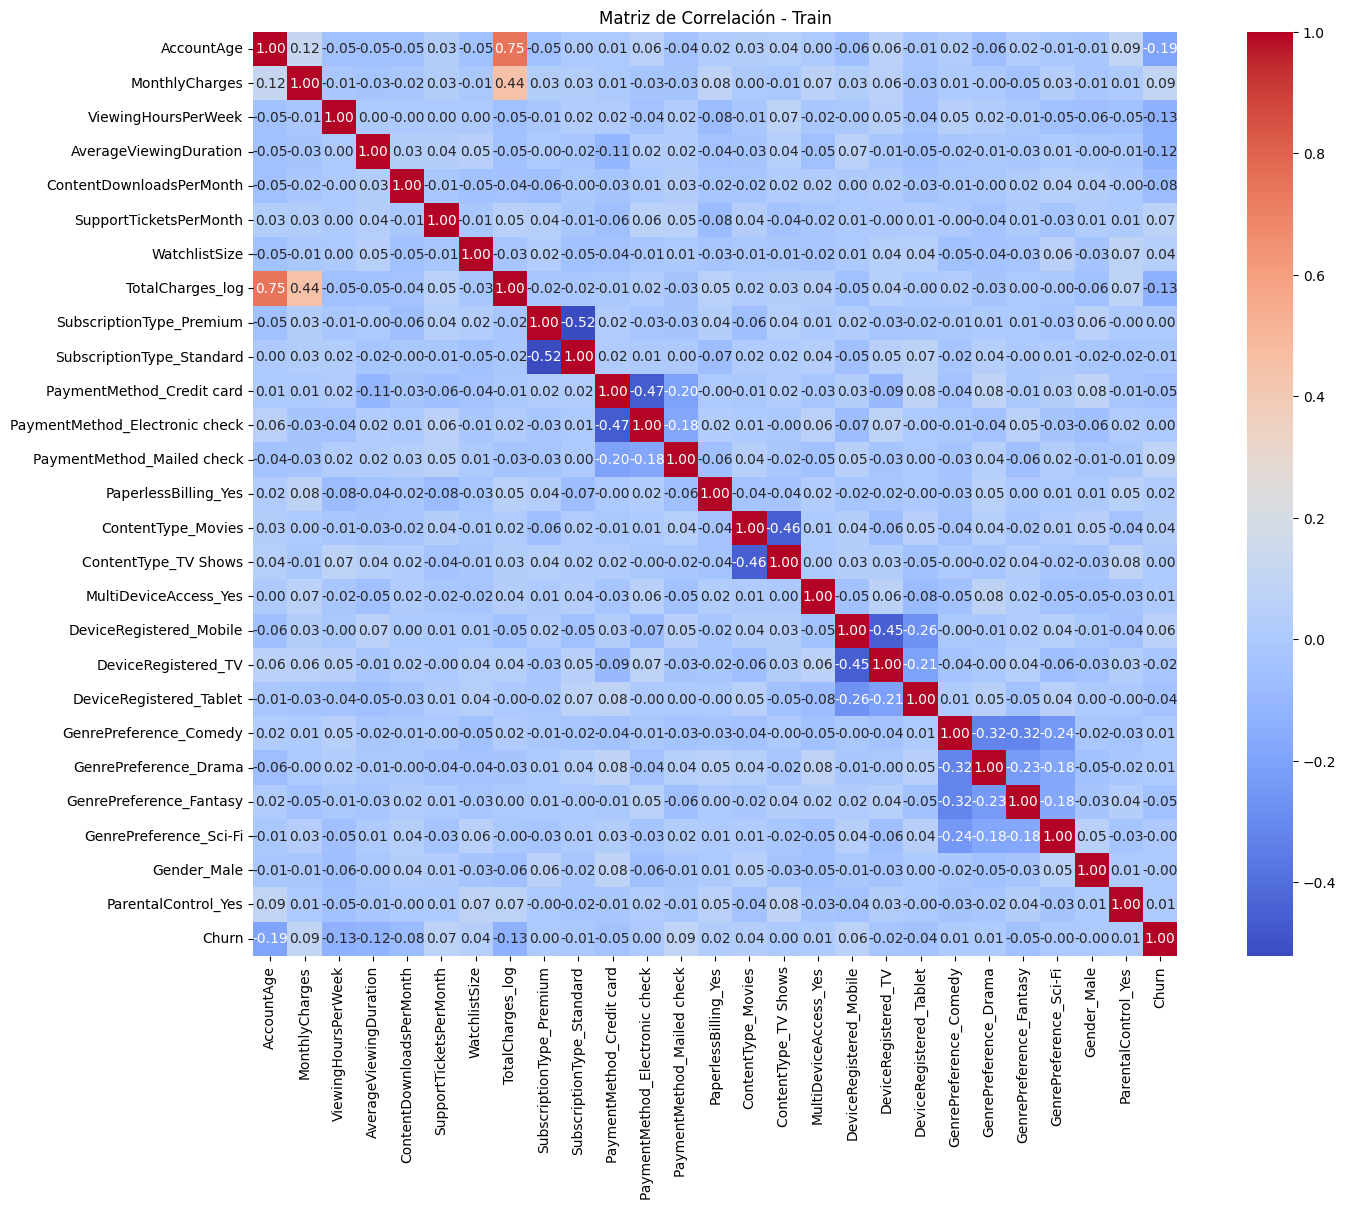

In [92]:
# Copiamos X_train y añadimos el target
train_corr = X_train_final.copy()
train_corr['Churn'] = y_train

# Calcular correlación
corr_matrix = train_corr.corr()


plt.figure(figsize=(18,12))

# Heatmap con anotaciones
sns.heatmap(
    corr_matrix,
    annot=True,            
    fmt=".2f",            
    cmap='coolwarm',       
    cbar=True,             
    square=True
)

plt.title("Matriz de Correlación - Train")
plt.show()

In [93]:
plt.savefig(r"C:\Users\LENOVO\Documents\GitHub\ML_PowerBI\reports\figures\corr_matrix.png", dpi=300)

<Figure size 640x480 with 0 Axes>

### 2.4 Escalado de variables numéricas para entrenar (StandardScaler)

In [94]:
# Columnas numéricas
numerical_cols = ['AccountAge', 'MonthlyCharges', 'TotalCharges_log', 
                  'ViewingHoursPerWeek', 'AverageViewingDuration', 
                  'ContentDownloadsPerMonth', 'SupportTicketsPerMonth',
                  'WatchlistSize']

scaler = StandardScaler()

# Escalar train y test
X_train_final[numerical_cols] = scaler.fit_transform(X_train_final[numerical_cols])
X_test_final[numerical_cols]  = scaler.transform(X_test_final[numerical_cols])

In [95]:
#Guardado del escalar para uso futuro
dump(scaler, r"C:\Users\LENOVO\Documents\GitHub\ML_PowerBI\models\scaler_final.joblib")

['C:\\Users\\LENOVO\\Documents\\GitHub\\ML_PowerBI\\models\\scaler_final.joblib']

In [96]:
 #Guardar los datasets procesados
X_train_final.to_csv(r'C:\Users\LENOVO\Documents\GitHub\ML_PowerBI\data\processed\X_train_final.csv', index=False)
X_test_final.to_csv(r'C:\Users\LENOVO\Documents\GitHub\ML_PowerBI\data\processed\X_test_final.csv', index=False)

In [97]:
X_train_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 770 entries, 621 to 102
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   AccountAge                      770 non-null    float64
 1   MonthlyCharges                  770 non-null    float64
 2   ViewingHoursPerWeek             770 non-null    float64
 3   AverageViewingDuration          770 non-null    float64
 4   ContentDownloadsPerMonth        770 non-null    float64
 5   SupportTicketsPerMonth          770 non-null    float64
 6   WatchlistSize                   770 non-null    float64
 7   TotalCharges_log                770 non-null    float64
 8   SubscriptionType_Premium        770 non-null    float64
 9   SubscriptionType_Standard       770 non-null    float64
 10  PaymentMethod_Credit card       770 non-null    float64
 11  PaymentMethod_Electronic check  770 non-null    float64
 12  PaymentMethod_Mailed check      770 non

In [98]:
print(X_test_final.index)

Index([529, 342, 352, 819, 277, 668, 215, 493,  86, 286,
       ...
       869, 513, 420, 957, 411, 552,  33,  31, 717, 662],
      dtype='int64', length=193)
